<a href="https://colab.research.google.com/github/marco-siino/Agentic-ORAN-LLM/blob/main/Mistral_EnergyCrisisSimulation_DRLvsA_LLM%2BDRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario 1 (Energy Crisis)

# Installazione librerie

In [16]:
!pip install mistralai gymnasium stable-baselines3 shimmy pandas matplotlib

# Esperimenti del 13/01/2025 - Da non eseguire

🚀 AVVIO SIMULAZIONE GYM + MISTRAL API...
Step 22/40 - Cell 2: Calling Mistral...API Error step 22: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 1: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 2: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 23/40 - Cell 3: Calling Mistral...API Error step 23: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}
Step 24/40 - Cell 1: Calling Mistral...API Error step 24: API error occurred: Status 429. Body: {"object":"error","message":"Rate limit exceeded","type":"rate_limited","param"

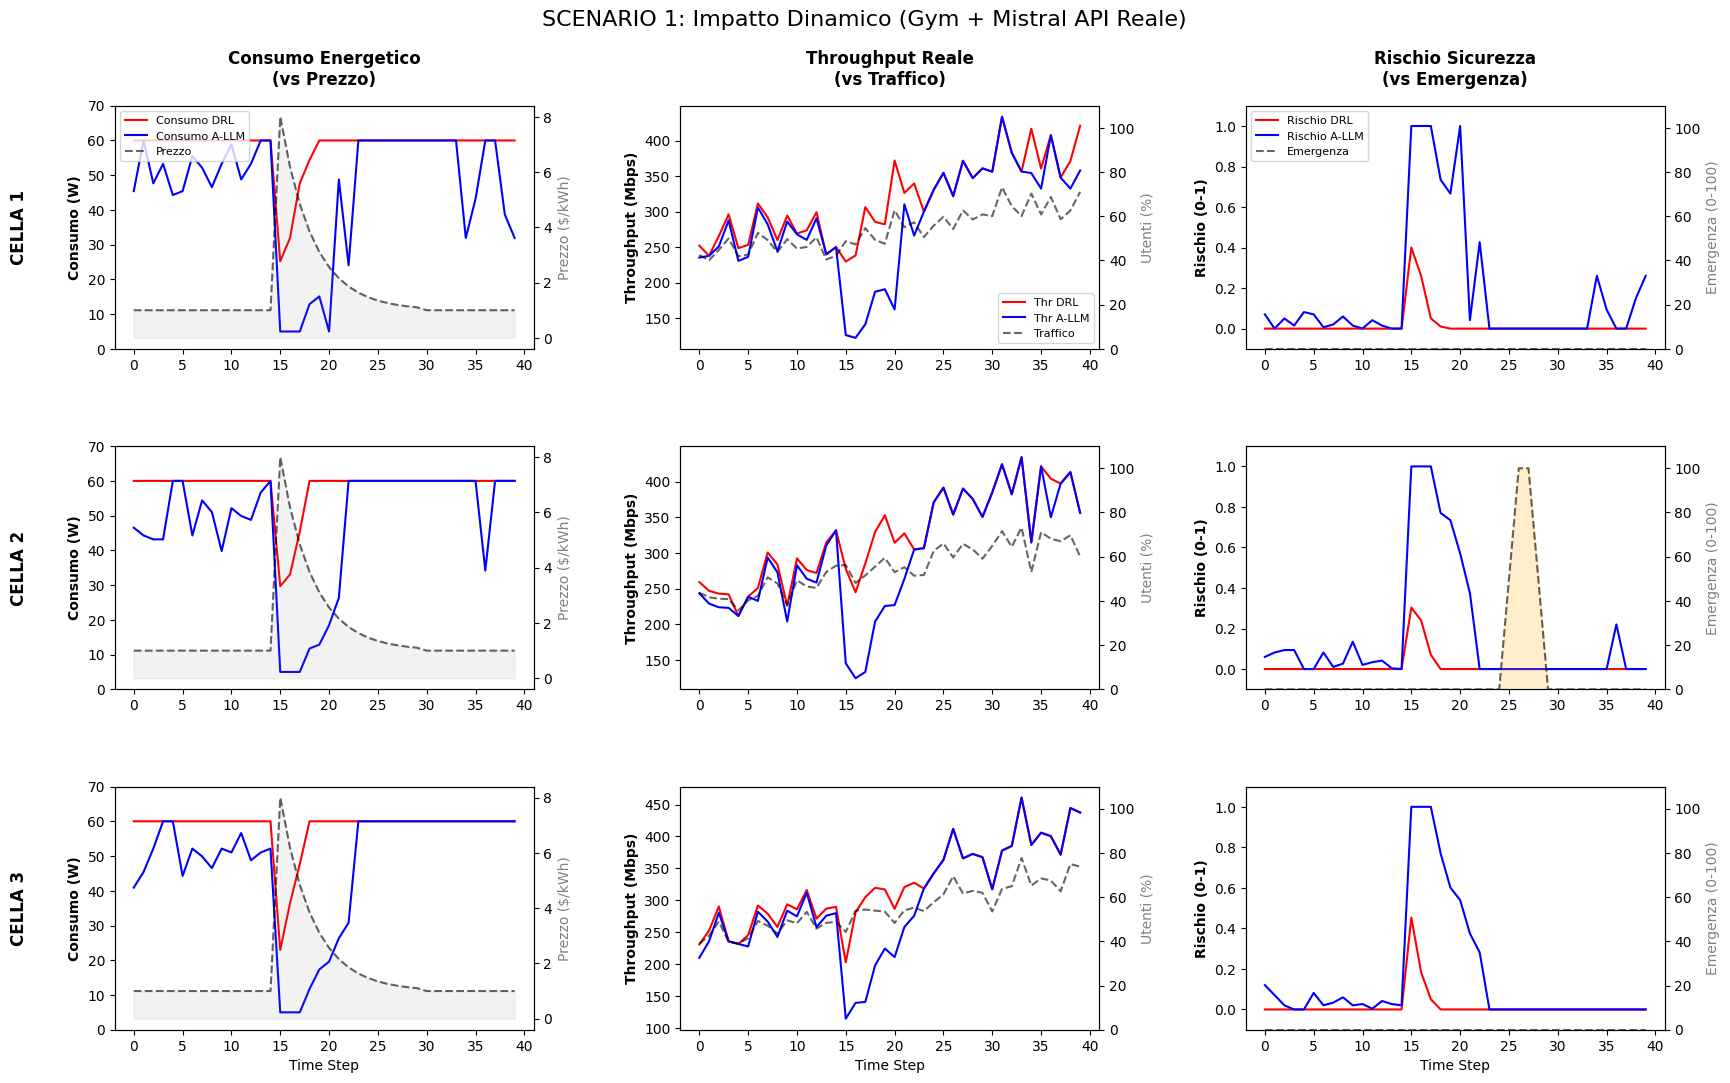

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY INSERITA
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"

# IMPORTANTE: Metti False per fare le chiamate reali (lento ma preciso).
# Metti True se vuoi solo testare i grafici velocemente senza consumare token.
USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL (Brain)
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    """
    Chiama Mistral per decidere i pesi DUF specifici per una cella.
    """
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0.
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        # Simulazione Fallback
        if safety_val > 50: return 0.0, 0.0, 1.0
        if price > 4.0: return 0.1, 0.9, 0.0
        return 0.7, 0.3, 0.0

    try:
        response = client.chat.complete(
            model=MODEL_NAME,
            messages=[{"role":"user", "content":prompt}]
        )
        content = response.choices[0].message.content
        clean_json = content.replace("```json", "").replace("```", "").strip()
        d = json.loads(clean_json)
        return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0))
    except Exception as e:
        # In caso di errore API (timeout o json malformato), fallback safe
        print(f"API Error step {step}: {e}")
        return 0.7, 0.3, 0.0

# ==============================================================================
# 3. AMBIENTE GYM O-RAN (Physics Engine)
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        # Azione: Potenza per le 3 celle (5W - 60W)
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        # Osservazione: Context vario
        self.observation_space = spaces.Box(low=0, high=100, shape=(10,), dtype=np.float32)

        # Parametri Fisici 5G
        self.bandwidth = 100.0 # MHz
        self.noise = 1.0       # Noise floor normalizzato
        self.max_pwr = 60.0
        self.min_pwr = 5.0

    def _calculate_metrics(self, power, traffic, price):
        # 1. Throughput (Shannon)
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)

        # 2. Consumo
        consumption = power
        cost = power * price

        # 3. Rischio (Quadratico inverso alla potenza)
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2
        return throughput, consumption, cost, risk

    def step(self, actions, context):
        """
        Calcola le metriche per le azioni date nel contesto corrente.
        """
        price = context['price']
        traffic_arr = context['traffic']

        metrics = []
        for i in range(self.n_cells):
            t, cons, c, r = self._calculate_metrics(actions[i], traffic_arr[i], price)
            metrics.append({'thr': t, 'cons': cons, 'cost': c, 'risk': r})

        return np.zeros(10), metrics, False, False, {}

# ==============================================================================
# 4. AGENTE OTTIMIZZATORE (DRL Solver)
# ==============================================================================
def optimize_power(w_thr, w_eng, w_safe, price, traffic, env_instance):
    """
    Trova la potenza P che massimizza la DUF data.
    """
    best_p = 5.0
    best_score = -np.inf

    # Grid search per trovare l'azione ottimale (Simula DRL Converged)
    for p in np.linspace(5, 60, 50):
        t, cons, c, r = env_instance._calculate_metrics(p, traffic, price)

        # Normalizzazione per DUF
        n_t = t / 800.0
        n_c = c / 600.0 # Max cost stimato
        n_r = r

        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if score > best_score:
            best_score = score
            best_p = p

    return best_p

# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE
# ==============================================================================
def run_experiment():
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- GENERAZIONE SCENARI REALISTICI ---

    # 1. PREZZO: Picco e Decadimento Esponenziale (Non lineare)
    prices = np.ones(steps)
    prices[15] = 8.0 # Shock
    for t in range(16, 30):
        # Decadimento esponenziale: P(t) = 1 + A * exp(-k*dt)
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    # 2. TRAFFICO: Trend + Rumore (Diverso per ogni cella)
    traffic_c = []
    np.random.seed(42) # Per riproducibilità
    base_trend = np.linspace(40, 70, steps) # Traffico sale leggermente nel tempo
    for i in range(3):
        # Aggiungiamo rumore diverso per ogni cella
        noise = np.random.normal(0, 5, steps)
        tr = base_trend + noise
        tr = np.clip(tr, 10, 100) # Clip 0-100%
        traffic_c.append(tr)

    # 3. SAFETY: Ambulanza solo in Cella 2
    safety_c2 = np.zeros(steps)
    # Emergenza sale e scende gradualmente
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print("🚀 AVVIO SIMULAZIONE GYM + MISTRAL API...")

    for t in range(steps):
        p = prices[t]

        row_data = {'Step': t, 'Price': p}

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            # --- 1. A-LLM (Agentic) ---
            print(f"\rStep {t}/40 - Cell {cid}: Calling Mistral...", end="")
            wa_t, wa_e, wa_s = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0 # Pesi fissi
            p_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # --- 3. GYM STEP ---
            # Calcoliamo metriche reali usando l'ambiente
            # Nota: facciamo due chiamate virtuali per ottenere le metriche dei due approcci
            # Usiamo metodi interni per non avanzare lo stato globale in modo conflittuale
            ta, cons_a, ca, ra = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b

            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb

            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

        history.append(row_data)

    print("\n✅ Simulazione Completata.")
    return pd.DataFrame(history)

# ==============================================================================
# 6. PLOTTING AGGIORNATO
# ==============================================================================
def plot_results(df):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.35) # Più spazio per le label

    cols = ["Consumo Energetico\n(vs Prezzo)", "Throughput Reale\n(vs Traffico)", "Rischio Sicurezza\n(vs Emergenza)"]
    for ax, t in zip(axes[0], cols): ax.set_title(t, fontweight='bold', pad=15)

    for i in range(3):
        cid = i + 1
        pid = f"C{cid}"

        # Etichetta Cella
        axes[i, 0].text(-0.25, 0.5, f"CELLA {cid}", transform=axes[i, 0].transAxes,
                        rotation=90, fontweight='bold', fontsize=12, va='center')

        # --- GRAFICO 1: CONSUMO (Sx) vs PREZZO (Dx) ---
        ax = axes[i, 0]
        l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', label='DRL (Baseline)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', label='A-LLM (Agentic)')
        ax.set_ylim(0, 70)
        ax.set_ylabel("Consumo (W)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.6, label='Prezzo Energia')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        ax2.set_ylabel("Prezzo ($/kWh)", color='gray') # <--- LABEL DX

        if i==0: ax.legend([l1, l2, l3], ['Consumo DRL', 'Consumo A-LLM', 'Prezzo'], loc='upper left', fontsize=8)

        # --- GRAFICO 2: THROUGHPUT (Sx) vs TRAFFICO (Dx) ---
        ax = axes[i, 1]
        l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-')
        ax.set_ylabel("Throughput (Mbps)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df[f'{pid}_Traffic'], 'k--', alpha=0.6)
        ax2.set_ylabel("Utenti (%)", color='gray') # <--- LABEL DX
        ax2.set_ylim(0, 110)

        if i==0: ax.legend([l1, l2, l3], ['Thr DRL', 'Thr A-LLM', 'Traffico'], loc='lower right', fontsize=8)

        # --- GRAFICO 3: RISCHIO (Sx) vs EMERGENZA (Dx) ---
        ax = axes[i, 2]
        l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-')
        l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-')
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("Rischio (0-1)", fontweight='bold') # <--- LABEL SX
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        safe_data = df[f'{pid}_Safety']
        l3, = ax2.plot(df['Step'], safe_data, 'k--', alpha=0.6)
        if safe_data.max() > 0:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Emergenza (0-100)", color='gray') # <--- LABEL DX
        ax2.set_ylim(0, 110)

        if i==0: ax.legend([l1, l2, l3], ['Rischio DRL', 'Rischio A-LLM', 'Emergenza'], loc='upper left', fontsize=8)

    plt.suptitle("SCENARIO 1: Impatto Dinamico (Gym + Mistral API Reale)", fontsize=16, y=0.96)
    plt.savefig("scenario1_gym_mistral.pdf", bbox_inches='tight')
    plt.show()

# ==============================================================================
# ESECUZIONE
# ==============================================================================
if __name__ == "__main__":
    df_results = run_experiment()
    plot_results(df_results)

🚀 STARTING SIMULATION (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 42.5% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {
  "w_thr": 0.5,
  "w_eng": 0.5,
  "w_safe": 0.0
}
       DECIDED WEIGHTS: W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       CHOSEN POWER:    45.4 W
       DUF SCORE:       0.1092
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.2320

  📍 CELL 2 [Load: 43.7% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng

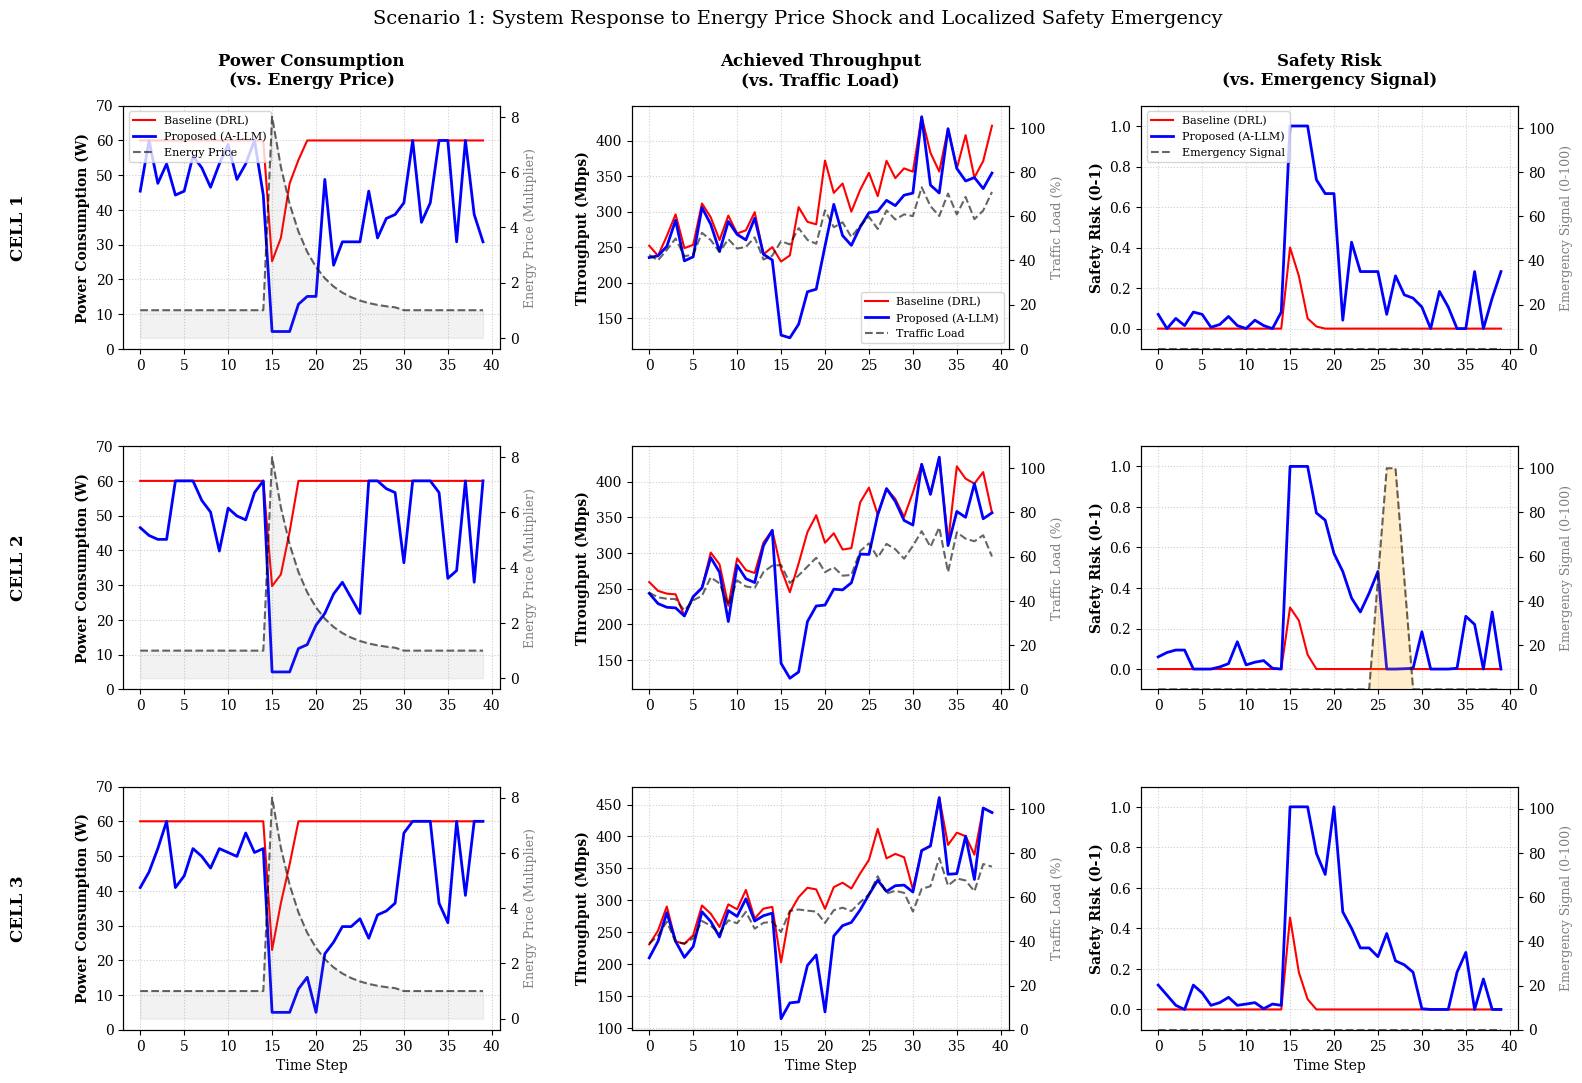

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"

# Metti False per vedere i log reali dell'LLM
USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL (Brain con RETRY LOGIC)
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    """
    Chiama Mistral. Se riceve errore 429 (Rate Limit), aspetta e riprova.
    """
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0.
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        if safety_val > 50: return 0.0, 0.0, 1.0, prompt, "MOCK_JSON"
        if price > 4.0: return 0.1, 0.9, 0.0, prompt, "MOCK_JSON"
        return 0.7, 0.3, 0.0, prompt, "MOCK_JSON"

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = client.chat.complete(
                model=MODEL_NAME,
                messages=[{"role":"user", "content":prompt}]
            )
            content = response.choices[0].message.content
            clean_json = content.replace("```json", "").replace("```", "").strip()
            d = json.loads(clean_json)
            return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0)), prompt, clean_json

        except Exception as e:
            error_str = str(e)
            if "429" in error_str or "Rate limit" in error_str:
                print(f"\n⚠️ Rate Limit (429) al Step {step}-Cella {cell_id}. Attendo 5s e riprovo ({attempt+1}/{max_retries})...")
                time.sleep(5) # Attesa di sicurezza
                continue # Riprova il loop
            else:
                print(f"\n❌ Errore API non recuperabile: {e}")
                return 0.7, 0.3, 0.0, prompt, "ERROR"

    # Se fallisce dopo i tentativi
    print("❌ Falliti tutti i tentativi di retry.")
    return 0.7, 0.3, 0.0, prompt, "ERROR_TIMEOUT"

# ==============================================================================
# 3. AMBIENTE GYM O-RAN
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(10,), dtype=np.float32)
        self.bandwidth = 100.0
        self.noise = 1.0
        self.max_pwr = 60.0
        self.min_pwr = 5.0

    def _calculate_metrics(self, power, traffic, price):
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)
        consumption = power
        cost = power * price
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2
        return throughput, consumption, cost, risk

# ==============================================================================
# 4. AGENTE OTTIMIZZATORE (DRL Solver)
# ==============================================================================
def optimize_power(w_thr, w_eng, w_safe, price, traffic, env_instance):
    best_p = 5.0
    best_score = -np.inf

    for p in np.linspace(5, 60, 50):
        t, cons, c, r = env_instance._calculate_metrics(p, traffic, price)
        n_t = t / 800.0
        n_c = c / 600.0
        n_r = r
        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)

        if score > best_score:
            best_score = score
            best_p = p

    return best_p, best_score

# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE
# ==============================================================================
def run_experiment():
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari ---
    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    np.random.seed(42)
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print("🚀 STARTING SIMULATION (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO PER EVITARE RATE LIMIT
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            ta, cons_a, ca, ra = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe
            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

        history.append(row_data)

    print("\n✅ Simulation Completed Successfully.")
    return pd.DataFrame(history)

# ==============================================================================
# 6. PLOTTING (ENGLISH FOR IEEE PAPERS)
# ==============================================================================
def plot_results(df):
    # Setup plot style parameters for IEEE papers
    plt.rcParams.update({'font.size': 10, 'font.family': 'serif'})

    fig, axes = plt.subplots(3, 3, figsize=(18, 12)) # Adjusted size slightly
    plt.subplots_adjust(hspace=0.4, wspace=0.35)

    # Column Titles (Formal English)
    cols = ["Power Consumption\n(vs. Energy Price)",
            "Achieved Throughput\n(vs. Traffic Load)",
            "Safety Risk\n(vs. Emergency Signal)"]

    for ax, t in zip(axes[0], cols):
        ax.set_title(t, fontweight='bold', pad=15)

    for i in range(3):
        cid = i + 1
        pid = f"C{cid}"

        # Row Labels: CELL 1, CELL 2, CELL 3
        axes[i, 0].text(-0.30, 0.5, f"CELL {cid}", transform=axes[i, 0].transAxes,
                        rotation=90, fontweight='bold', fontsize=12, va='center')

        # --- COLUMN 1: Power Consumption vs Price ---
        ax = axes[i, 0]
        # Primary Axis (Power)
        l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', linewidth=1.5, label='Baseline (DRL)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', linewidth=2.0, label='Proposed (A-LLM)')
        ax.set_ylim(0, 70)
        ax.set_ylabel("Power Consumption (W)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        # Secondary Axis (Price)
        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df['Price'], 'k--', linewidth=1.5, alpha=0.6, label='Energy Price')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        ax2.set_ylabel("Energy Price (Multiplier)", color='gray', fontsize=9)

        # Legend only on first plot
        if i==0:
            # Combined legend for dual axis
            lines = [l1, l2, l3]
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper left', fontsize=8, frameon=True)

        # --- COLUMN 2: Throughput vs Traffic ---
        ax = axes[i, 1]
        l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-', linewidth=1.5)
        l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-', linewidth=2.0)
        ax.set_ylabel("Throughput (Mbps)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df[f'{pid}_Traffic'], 'k--', linewidth=1.5, alpha=0.6)
        ax2.set_ylabel("Traffic Load (%)", color='gray', fontsize=9)
        ax2.set_ylim(0, 110)

        if i==0:
            ax.legend([l1, l2, l3], ['Baseline (DRL)', 'Proposed (A-LLM)', 'Traffic Load'],
                      loc='lower right', fontsize=8, frameon=True)

        # --- COLUMN 3: Risk vs Safety ---
        ax = axes[i, 2]
        l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-', linewidth=1.5)
        l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-', linewidth=2.0)
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("Safety Risk (0-1)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        safe_data = df[f'{pid}_Safety']
        l3, = ax2.plot(df['Step'], safe_data, 'k--', linewidth=1.5, alpha=0.6)
        if safe_data.max() > 0:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Emergency Signal (0-100)", color='gray', fontsize=9)
        ax2.set_ylim(0, 110)

        if i==0:
            ax.legend([l1, l2, l3], ['Baseline (DRL)', 'Proposed (A-LLM)', 'Emergency Signal'],
                      loc='upper left', fontsize=8, frameon=True)

    plt.suptitle("Scenario 1: System Response to Energy Price Shock and Localized Safety Emergency",
                 fontsize=14, y=0.96)

    filename = "scenario1_ieee_tccn_results.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"✅ Plot saved to {filename}")
    plt.show()

if __name__ == "__main__":
    df_results = run_experiment()
    plot_results(df_results)

# Esperimenti finali Paper

In [17]:
import os
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from mistralai import Mistral

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================
API_KEY = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5' # <--- TUA KEY
client = Mistral(api_key=API_KEY)
MODEL_NAME = "mistral-small-latest"
USE_MOCK_LLM = False

# ==============================================================================
# 2. LOGICA MISTRAL
# ==============================================================================
def get_llm_weights_per_cell(step, cell_id, price, traffic, safety_val):
    prompt = f"""
    Context (Step {step}, Cell {cell_id}):
    - Energy Price: {price:.2f}x (Normal=1.0)
    - Traffic: {traffic:.0f}%
    - Safety Criticality: {safety_val:.0f}/100 (Normal=0, Emergency>80)

    Task: Output JSON weights (w_thr, w_eng, w_safe) summing to 1.0.
    Logic:
    1. Emergency (>80): w_safe must be 1.0.
    2. High Price (>5) & Safe: w_eng > 0.9.
    3. Normal: Balance w_thr and w_eng.

    Output JSON ONLY: {{"w_thr": float, "w_eng": float, "w_safe": float}}
    """

    if USE_MOCK_LLM:
        if safety_val > 50: return 0.0, 0.0, 1.0, prompt, "MOCK"
        if price > 4.0: return 0.1, 0.9, 0.0, prompt, "MOCK"
        return 0.7, 0.3, 0.0, prompt, "MOCK"

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = client.chat.complete(model=MODEL_NAME, messages=[{"role":"user", "content":prompt}])
            content = response.choices[0].message.content
            clean_json = content.replace("```json", "").replace("```", "").strip()
            d = json.loads(clean_json)
            return float(d.get('w_thr', 0.3)), float(d.get('w_eng', 0.3)), float(d.get('w_safe', 0.0)), prompt, clean_json
        except Exception as e:
            time.sleep(1)
            continue
    return 0.7, 0.3, 0.0, prompt, "ERROR_TIMEOUT"

# ==============================================================================
# 3. AMBIENTE GYM O-RAN (Con SLA e Fairness)
# ==============================================================================
class ORAN3CellsEnv(gym.Env):
    def __init__(self):
        super(ORAN3CellsEnv, self).__init__()
        self.n_cells = 3
        self.action_space = spaces.Box(low=5.0, high=60.0, shape=(3,), dtype=np.float32)
        self.bandwidth = 100.0
        self.noise = 1.0
        self.max_pwr = 60.0
        self.min_pwr = 5.0

    def _calculate_metrics(self, power, traffic, price):
        snr = power / self.noise
        capacity = self.bandwidth * np.log2(1 + snr)
        throughput = capacity * (traffic / 100.0)
        consumption = power
        cost = power * price
        risk = ((self.max_pwr - power) / (self.max_pwr - self.min_pwr))**2

        # --- NUOVE METRICHE AGGIUNTE PER LA TABELLA ---
        # SLA Violation: Throughput < 50 Mbps con traffico attivo (>10%)
        sla_violation = 1.0 if (throughput < 50.0 and traffic > 10.0) else 0.0
        # Jain's Fairness Proxy: Cala linearmente con il carico
        fairness = max(0.5, 1.0 - (traffic/200.0))

        return throughput, consumption, cost, risk, sla_violation, fairness

# ==============================================================================
# 4. AGENTE OTTIMIZZATORE
# ==============================================================================
def optimize_power(w_thr, w_eng, w_safe, price, traffic, env_instance):
    best_p = 5.0
    best_score = -np.inf
    for p in np.linspace(5, 60, 50):
        # Nota: unpack delle 6 metriche
        t, cons, c, r, _, _ = env_instance._calculate_metrics(p, traffic, price)
        n_t = t / 800.0
        n_c = c / 600.0
        n_r = r
        score = (w_thr * n_t) - (w_eng * n_c) - (w_safe * n_r)
        if score > best_score:
            best_score = score
            best_p = p
    return best_p, best_score

In [18]:
# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE (RUN SINGOLA)
# ==============================================================================

# --- CAMBIA QUESTO ID IN OGNI CELLA (0, 1, 2, 3, 4) ---
RUN_ID = 0
# ------------------------------------------------------

def run_experiment_single(run_id):
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari (SEED DIVERSO) ---
    np.random.seed(42 + run_id) # <--- Seed Variabile

    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print(f"🚀 STARTING SIMULATION RUN {run_id} (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM (MANTENUTO)
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE (MANTENUTO)
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            # Calcoliamo tutte le metriche (SLA e Fair inclusi)
            ta, cons_a, ca, ra, slaa, faira = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb, slab, fairb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Cost_A'] = ca
            row_data[f'{prefix}_Cost_B'] = cb
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

            # Save Advanced Metrics (per tabella)
            row_data[f'{prefix}_SLA_A'] = slaa
            row_data[f'{prefix}_Fair_A'] = faira
            row_data[f'{prefix}_SLA_B'] = slab
            row_data[f'{prefix}_Fair_B'] = fairb

        history.append(row_data)

    print(f"\n✅ Simulation Run {run_id} Completed.")

    # SALVATAGGIO FONDAMENTALE PER LA TABELLA
    df = pd.DataFrame(history)
    df.to_json(f"results_run_{run_id}.json")
    return df

# ESECUZIONE
df_res = run_experiment_single(RUN_ID)

🚀 STARTING SIMULATION RUN 0 (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 42.5% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {
  "w_thr": 0.5,
  "w_eng": 0.5,
  "w_safe": 0.0
}
       DECIDED WEIGHTS: W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       CHOSEN POWER:    45.4 W
       DUF SCORE:       0.1092
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.2320

  📍 CELL 2 [Load: 43.7% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \

📊 Loading data from results_run_0.json for plotting...
✅ Plot generated and saved to: scenario1_ieee_tccn_results.pdf


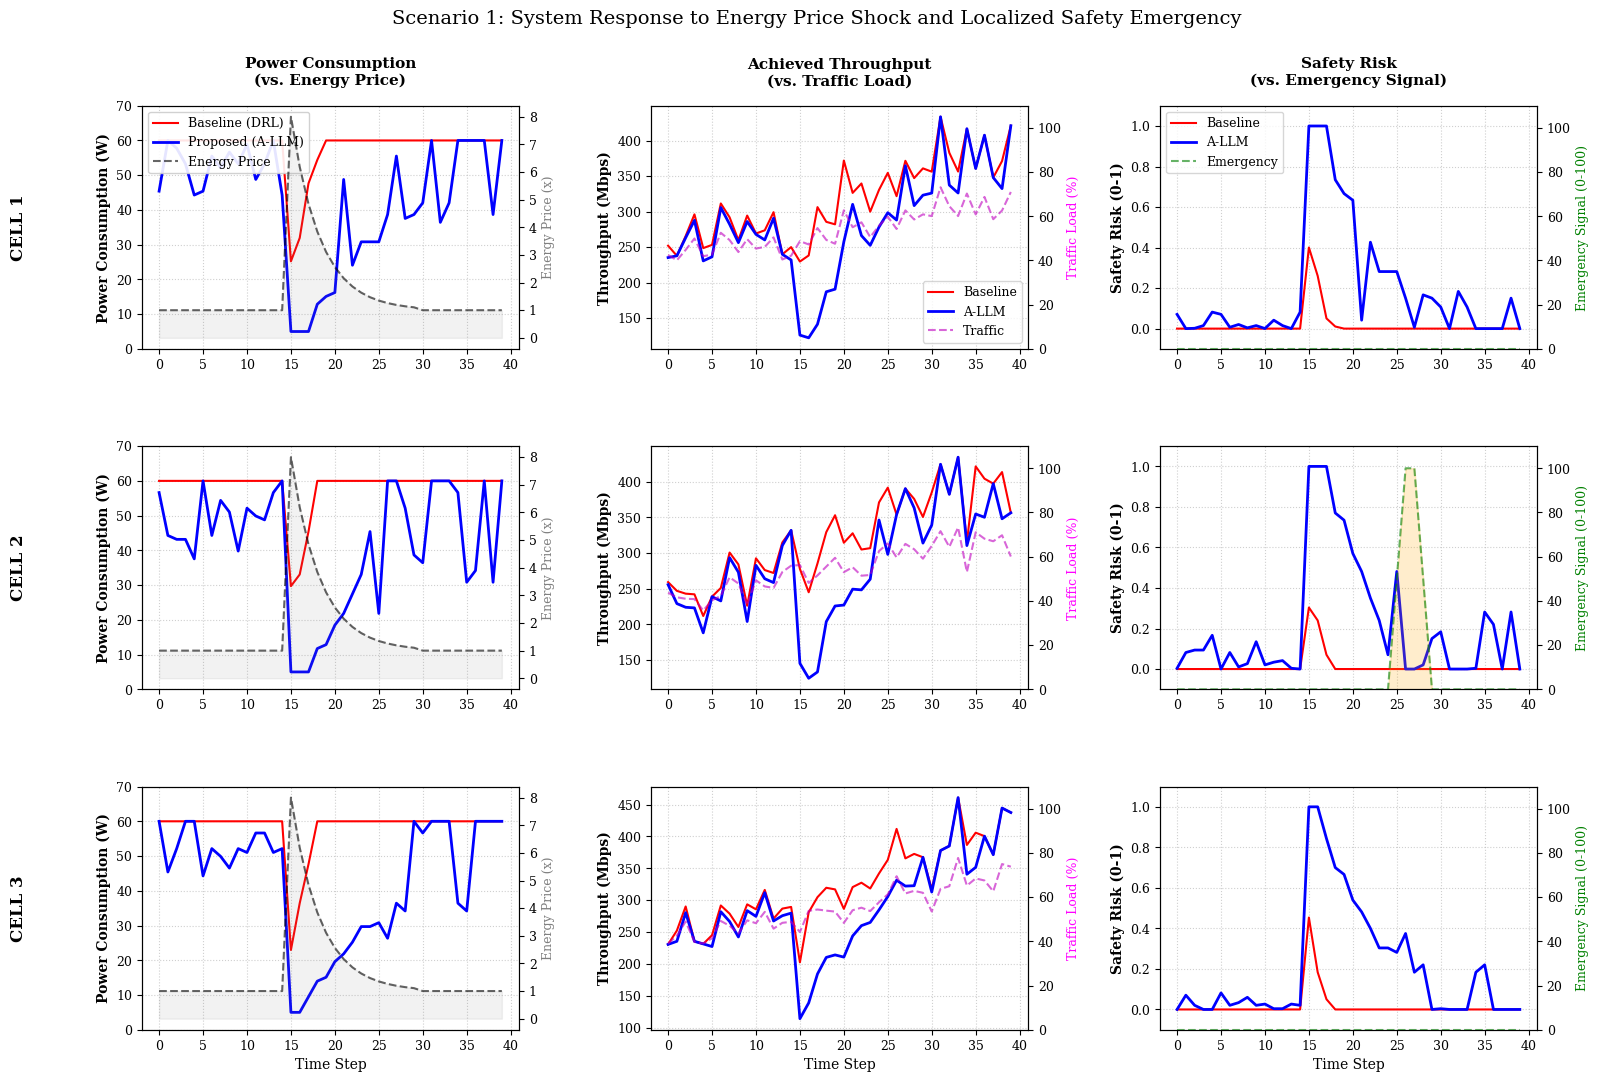

In [19]:
# ==============================================================================
# CELLA 4: GENERAZIONE GRAFICI E PDF (IEEE STYLE)
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt

def generate_plots(run_id_to_plot=0):
    # Carica i dati di una run specifica (la 0 è solitamente rappresentativa)
    filename = f"results_run_{run_id_to_plot}.json"
    try:
        df = pd.read_json(filename)
        print(f"📊 Loading data from {filename} for plotting...")
    except:
        print(f"❌ Error: Could not find {filename}. Make sure to run the simulation first.")
        return

    # Setup parametri grafici per IEEE Papers
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 11,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'lines.linewidth': 1.5,
        'figure.titlesize': 13
    })

    # Creazione Figura 3x3
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)

    # Titoli delle Colonne
    cols = ["Power Consumption\n(vs. Energy Price)",
            "Achieved Throughput\n(vs. Traffic Load)",
            "Safety Risk\n(vs. Emergency Signal)"]

    for ax, t in zip(axes[0], cols):
        ax.set_title(t, fontweight='bold', pad=15)

    # Iterazione sulle 3 Celle (Righe)
    for i in range(3):
        cid = i + 1
        pid = f"C{cid}" # Prefisso colonne (es. C1, C2, C3)

        # Etichetta laterale (CELL 1, CELL 2...)
        axes[i, 0].text(-0.35, 0.5, f"CELL {cid}", transform=axes[i, 0].transAxes,
                        rotation=90, fontweight='bold', fontsize=12, va='center')

        # --- COLONNA 1: Power (Sx) vs Price (Dx) ---
        ax = axes[i, 0]
        # Linee Solide (Agenti)
        l1, = ax.plot(df['Step'], df[f'{pid}_Cons_B'], 'r-', label='Baseline (DRL)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Cons_A'], 'b-', linewidth=2.0, label='Proposed (A-LLM)')
        ax.set_ylim(0, 70)
        ax.set_ylabel("Power Consumption (W)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        # Asse Secondario (Prezzo)
        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df['Price'], 'k--', alpha=0.6, label='Energy Price')
        ax2.fill_between(df['Step'], 0, df['Price'], color='gray', alpha=0.1)
        ax2.set_ylabel("Energy Price (x)", color='gray', fontsize=9)

        # Legenda (solo nel primo grafico)
        if i==0:
            lines = [l1, l2, l3]
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, framealpha=0.9)

        # --- COLONNA 2: Throughput (Sx) vs Traffic (Dx) ---
        ax = axes[i, 1]
        l1, = ax.plot(df['Step'], df[f'{pid}_Thr_B'], 'r-', label='Baseline (DRL)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Thr_A'], 'b-', linewidth=2.0, label='Proposed (A-LLM)')
        ax.set_ylabel("Throughput (Mbps)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        l3, = ax2.plot(df['Step'], df[f'{pid}_Traffic'], 'm--', alpha=0.6, label='Traffic Load')
        ax2.set_ylabel("Traffic Load (%)", color='magenta', fontsize=9)
        ax2.set_ylim(0, 110)

        if i==0:
            ax.legend([l1, l2, l3], ['Baseline', 'A-LLM', 'Traffic'], loc='lower right', frameon=True)

        # --- COLONNA 3: Risk (Sx) vs Safety Signal (Dx) ---
        ax = axes[i, 2]
        l1, = ax.plot(df['Step'], df[f'{pid}_Risk_B'], 'r-', label='Baseline (DRL)')
        l2, = ax.plot(df['Step'], df[f'{pid}_Risk_A'], 'b-', linewidth=2.0, label='Proposed (A-LLM)')
        ax.set_ylim(-0.1, 1.1)
        ax.set_ylabel("Safety Risk (0-1)", fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        if i==2: ax.set_xlabel("Time Step")

        ax2 = ax.twinx()
        safe_data = df[f'{pid}_Safety']
        l3, = ax2.plot(df['Step'], safe_data, 'g--', linewidth=1.5, alpha=0.6, label='Emergency Flag')
        if safe_data.max() > 0:
            ax2.fill_between(df['Step'], 0, safe_data, color='orange', alpha=0.2)
        ax2.set_ylabel("Emergency Signal (0-100)", color='green', fontsize=9)
        ax2.set_ylim(0, 110)

        if i==0:
            ax.legend([l1, l2, l3], ['Baseline', 'A-LLM', 'Emergency'], loc='upper left', frameon=True)

    # Titolo Globale
    plt.suptitle("Scenario 1: System Response to Energy Price Shock and Localized Safety Emergency",
                 fontsize=14, y=0.96)

    # Salvataggio PDF
    pdf_filename = "scenario1_ieee_tccn_results.pdf"
    plt.savefig(pdf_filename, bbox_inches='tight', dpi=300)
    print(f"✅ Plot generated and saved to: {pdf_filename}")
    plt.show()

# Esegui la funzione
if __name__ == "__main__":
    generate_plots(run_id_to_plot=0) # Usa i dati della prima run come rappresentativa

## Run 1

In [20]:
# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE (RUN SINGOLA)
# ==============================================================================

# --- CAMBIA QUESTO ID IN OGNI CELLA (0, 1, 2, 3, 4) ---
RUN_ID = 1
# ------------------------------------------------------

def run_experiment_single(run_id):
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari (SEED DIVERSO) ---
    np.random.seed(42 + run_id) # <--- Seed Variabile

    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print(f"🚀 STARTING SIMULATION RUN {run_id} (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM (MANTENUTO)
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE (MANTENUTO)
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            # Calcoliamo tutte le metriche (SLA e Fair inclusi)
            ta, cons_a, ca, ra, slaa, faira = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb, slab, fairb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Cost_A'] = ca
            row_data[f'{prefix}_Cost_B'] = cb
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

            # Save Advanced Metrics (per tabella)
            row_data[f'{prefix}_SLA_A'] = slaa
            row_data[f'{prefix}_Fair_A'] = faira
            row_data[f'{prefix}_SLA_B'] = slab
            row_data[f'{prefix}_Fair_B'] = fairb

        history.append(row_data)

    print(f"\n✅ Simulation Run {run_id} Completed.")

    # SALVATAGGIO FONDAMENTALE PER LA TABELLA
    df = pd.DataFrame(history)
    df.to_json(f"results_run_{run_id}.json")
    return df

# ESECUZIONE
df_res = run_experiment_single(RUN_ID)

🚀 STARTING SIMULATION RUN 1 (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 41.3% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {
  "w_thr": 0.5,
  "w_eng": 0.5,
  "w_safe": 0.0
}
       DECIDED WEIGHTS: W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       CHOSEN POWER:    43.2 W
       DUF SCORE:       0.1050
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.2249

  📍 CELL 2 [Load: 46.1% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \

## Run 2

In [23]:
# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE (RUN SINGOLA)
# ==============================================================================

# --- CAMBIA QUESTO ID IN OGNI CELLA (0, 1, 2, 3, 4) ---
RUN_ID = 2
# ------------------------------------------------------

def run_experiment_single(run_id):
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari (SEED DIVERSO) ---
    np.random.seed(42 + run_id) # <--- Seed Variabile

    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print(f"🚀 STARTING SIMULATION RUN {run_id} (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM (MANTENUTO)
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE (MANTENUTO)
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            # Calcoliamo tutte le metriche (SLA e Fair inclusi)
            ta, cons_a, ca, ra, slaa, faira = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb, slab, fairb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Cost_A'] = ca
            row_data[f'{prefix}_Cost_B'] = cb
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

            # Save Advanced Metrics (per tabella)
            row_data[f'{prefix}_SLA_A'] = slaa
            row_data[f'{prefix}_Fair_A'] = faira
            row_data[f'{prefix}_SLA_B'] = slab
            row_data[f'{prefix}_Fair_B'] = fairb

        history.append(row_data)

    print(f"\n✅ Simulation Run {run_id} Completed.")

    # SALVATAGGIO FONDAMENTALE PER LA TABELLA
    df = pd.DataFrame(history)
    df.to_json(f"results_run_{run_id}.json")
    return df

# ESECUZIONE
df_res = run_experiment_single(RUN_ID)

🚀 STARTING SIMULATION RUN 2 (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 36.2% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {"w_thr": 0.5, "w_eng": 0.5, "w_safe": 0.0}
       DECIDED WEIGHTS: W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       CHOSEN POWER:    38.7 W
       DUF SCORE:       0.0881
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.1950

  📍 CELL 2 [Load: 36.5% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\"

## Run 3

In [24]:
# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE (RUN SINGOLA)
# ==============================================================================

# --- CAMBIA QUESTO ID IN OGNI CELLA (0, 1, 2, 3, 4) ---
RUN_ID = 3
# ------------------------------------------------------

def run_experiment_single(run_id):
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari (SEED DIVERSO) ---
    np.random.seed(42 + run_id) # <--- Seed Variabile

    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print(f"🚀 STARTING SIMULATION RUN {run_id} (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM (MANTENUTO)
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE (MANTENUTO)
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            # Calcoliamo tutte le metriche (SLA e Fair inclusi)
            ta, cons_a, ca, ra, slaa, faira = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb, slab, fairb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Cost_A'] = ca
            row_data[f'{prefix}_Cost_B'] = cb
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

            # Save Advanced Metrics (per tabella)
            row_data[f'{prefix}_SLA_A'] = slaa
            row_data[f'{prefix}_Fair_A'] = faira
            row_data[f'{prefix}_SLA_B'] = slab
            row_data[f'{prefix}_Fair_B'] = fairb

        history.append(row_data)

    print(f"\n✅ Simulation Run {run_id} Completed.")

    # SALVATAGGIO FONDAMENTALE PER LA TABELLA
    df = pd.DataFrame(history)
    df.to_json(f"results_run_{run_id}.json")
    return df

# ESECUZIONE
df_res = run_experiment_single(RUN_ID)

🚀 STARTING SIMULATION RUN 3 (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 40.1% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {"w_thr": 0.6, "w_eng": 0.4, "w_safe": 0.0}
       DECIDED WEIGHTS: W_Thr=0.60, W_Eng=0.40, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.1385
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.2180

  📍 CELL 2 [Load: 41.1% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\"

## Run 4

In [25]:
# ==============================================================================
# 5. ESECUZIONE SIMULAZIONE (RUN SINGOLA)
# ==============================================================================

# --- CAMBIA QUESTO ID IN OGNI CELLA (0, 1, 2, 3, 4) ---
RUN_ID = 4
# ------------------------------------------------------

def run_experiment_single(run_id):
    env = ORAN3CellsEnv()
    steps = 40
    history = []

    # --- Generazione Scenari (SEED DIVERSO) ---
    np.random.seed(42 + run_id) # <--- Seed Variabile

    prices = np.ones(steps)
    prices[15] = 8.0
    for t in range(16, 30):
        prices[t] = 1.0 + 7.0 * np.exp(-0.3 * (t-15))

    traffic_c = []
    base_trend = np.linspace(40, 70, steps)
    for i in range(3):
        noise = np.random.normal(0, 5, steps)
        tr = np.clip(base_trend + noise, 10, 100)
        traffic_c.append(tr)

    safety_c2 = np.zeros(steps)
    safety_c2[25] = 50.0
    safety_c2[26:28] = 100.0
    safety_c2[28] = 50.0

    print(f"🚀 STARTING SIMULATION RUN {run_id} (IEEE TCCN SCENARIO)...")

    for t in range(steps):
        p = prices[t]
        row_data = {'Step': t, 'Price': p}

        print(f"\n{'='*80}")
        print(f"⏰ TIMESTEP {t} | Price Factor: {p:.2f}x")
        print(f"{'='*80}")

        # Iteriamo sulle 3 Celle
        for i in range(3):
            cid = i + 1
            tr = traffic_c[i][t]
            safe = safety_c2[t] if cid == 2 else 0.0

            print(f"\n  📍 CELL {cid} [Load: {tr:.1f}% | Safety: {safe:.0f}]")

            # AGGIUNTO SLEEP PREVENTIVO
            time.sleep(1.1)

            # --- 1. A-LLM (Agentic) ---
            wa_t, wa_e, wa_s, prompt_txt, json_resp = get_llm_weights_per_cell(t, cid, p, tr, safe)
            p_agentic, duf_agentic = optimize_power(wa_t, wa_e, wa_s, p, tr, env)

            # LOG TRASPARENZA A-LLM (MANTENUTO)
            print(f"    🔸 [A-LLM INTERACTION]")
            print(f"       PROMPT TAIL:     ...{json.dumps(prompt_txt.strip()[-200:])}")
            print(f"       OUTPUT JSON:     {json_resp}")
            print(f"       DECIDED WEIGHTS: W_Thr={wa_t:.2f}, W_Eng={wa_e:.2f}, W_Safe={wa_s:.2f}")
            print(f"       CHOSEN POWER:    {p_agentic:.1f} W")
            print(f"       DUF SCORE:       {duf_agentic:.4f}")

            # --- 2. DRL (Baseline) ---
            wb_t, wb_e, wb_s = 0.8, 0.2, 0.0
            p_baseline, duf_baseline = optimize_power(wb_t, wb_e, wb_s, p, tr, env)

            # LOG TRASPARENZA BASELINE (MANTENUTO)
            print(f"    🔹 [BASELINE DRL]")
            print(f"       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00")
            print(f"       CHOSEN POWER:    {p_baseline:.1f} W")
            print(f"       DUF SCORE:       {duf_baseline:.4f}")

            # --- 3. METRICHE FISICHE ---
            # Calcoliamo tutte le metriche (SLA e Fair inclusi)
            ta, cons_a, ca, ra, slaa, faira = env._calculate_metrics(p_agentic, tr, p)
            tb, cons_b, cb, rb, slab, fairb = env._calculate_metrics(p_baseline, tr, p)

            # Save Data
            prefix = f"C{cid}"
            row_data[f'{prefix}_Traffic'] = tr
            row_data[f'{prefix}_Safety'] = safe

            row_data[f'{prefix}_Cons_A'] = cons_a
            row_data[f'{prefix}_Cons_B'] = cons_b
            row_data[f'{prefix}_Cost_A'] = ca
            row_data[f'{prefix}_Cost_B'] = cb
            row_data[f'{prefix}_Thr_A'] = ta
            row_data[f'{prefix}_Thr_B'] = tb
            row_data[f'{prefix}_Risk_A'] = ra
            row_data[f'{prefix}_Risk_B'] = rb

            # Save Advanced Metrics (per tabella)
            row_data[f'{prefix}_SLA_A'] = slaa
            row_data[f'{prefix}_Fair_A'] = faira
            row_data[f'{prefix}_SLA_B'] = slab
            row_data[f'{prefix}_Fair_B'] = fairb

        history.append(row_data)

    print(f"\n✅ Simulation Run {run_id} Completed.")

    # SALVATAGGIO FONDAMENTALE PER LA TABELLA
    df = pd.DataFrame(history)
    df.to_json(f"results_run_{run_id}.json")
    return df

# ESECUZIONE
df_res = run_experiment_single(RUN_ID)

🚀 STARTING SIMULATION RUN 4 (IEEE TCCN SCENARIO)...

⏰ TIMESTEP 0 | Price Factor: 1.00x

  📍 CELL 1 [Load: 42.9% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\": float, \"w_safe\": float}"
       OUTPUT JSON:     {"w_thr": 0.5, "w_eng": 0.5, "w_safe": 0.0}
       DECIDED WEIGHTS: W_Thr=0.50, W_Eng=0.50, W_Safe=0.00
       CHOSEN POWER:    45.4 W
       DUF SCORE:       0.1107
    🔹 [BASELINE DRL]
       STATIC WEIGHTS:  W_Thr=0.80, W_Eng=0.20, W_Safe=0.00
       CHOSEN POWER:    60.0 W
       DUF SCORE:       0.2346

  📍 CELL 2 [Load: 26.5% | Safety: 0]
    🔸 [A-LLM INTERACTION]
       PROMPT TAIL:     ..."    1. Emergency (>80): w_safe must be 1.0.\n    2. High Price (>5) & Safe: w_eng > 0.9.\n    3. Normal: Balance w_thr and w_eng.\n\n    Output JSON ONLY: {\"w_thr\": float, \"w_eng\"

# Generazione tabella latex

In [26]:
# ==============================================================================
# CELLA 3: GENERATORE TABELLA (NO CMIDRULE, SLA DECIMALE, TOPRULE EVENTO 2)
# ==============================================================================
import pandas as pd
import numpy as np

def generate_paper_table_structural_sep(num_runs_to_analyze):
    RECALC_SLA_THR = 330.0

    results = {
        'Shock': {1: {}, 2: {}, 3: {}, 'Global': {}},
        'Emerg': {1: {}, 2: {}, 3: {}, 'Global': {}}
    }

    for evt in ['Shock', 'Emerg']:
        for c in [1, 2, 3, 'Global']:
            for m in ['Base', 'Agent']:
                results[evt][c][m] = {'thr':[], 'cost':[], 'pwr':[], 'sla':[], 'risk':[]}

    print(f"📊 Processing {num_runs_to_analyze} runs...")

    for i in range(num_runs_to_analyze):
        fname = f"results_run_{i}.json"
        try:
            df = pd.read_json(fname)
        except:
            continue

        df_Shock = df[(df['Step'] >= 15) & (df['Step'] < 30)]
        df_Emerg = df[(df['Step'] >= 26) & (df['Step'] < 29)]

        events = {'Shock': df_Shock, 'Emerg': df_Emerg}

        for evt_name, df_cut in events.items():
            for cid in [1, 2, 3]:
                pre = f"C{cid}"
                traf_col = f'{pre}_Traffic'
                for m_type, suffix in [('Base', '_B'), ('Agent', '_A')]:
                    thr_col = f'{pre}_Thr{suffix}'

                    results[evt_name][cid][m_type]['thr'].append(df_cut[thr_col].mean())
                    results[evt_name][cid][m_type]['cost'].append(df_cut[f'{pre}_Cost{suffix}'].mean())
                    results[evt_name][cid][m_type]['pwr'].append(df_cut[f'{pre}_Cons{suffix}'].mean())
                    results[evt_name][cid][m_type]['risk'].append(df_cut[f'{pre}_Risk{suffix}'].mean())

                    # Calcolo SLA (0 o 1 per step)
                    sla_series = ((df_cut[thr_col] < RECALC_SLA_THR) & (df_cut[traf_col] > 10.0)).astype(float)
                    results[evt_name][cid][m_type]['sla'].append(sla_series.mean())

            for m_type, suffix in [('Base', '_B'), ('Agent', '_A')]:
                # Globali
                mean_thr = df_cut[[f'C{k}_Thr{suffix}' for k in [1,2,3]]].mean().mean()
                mean_cost = df_cut[[f'C{k}_Cost{suffix}' for k in [1,2,3]]].mean().mean()
                mean_pwr = df_cut[[f'C{k}_Cons{suffix}' for k in [1,2,3]]].mean().mean()
                mean_risk = df_cut[[f'C{k}_Risk{suffix}' for k in [1,2,3]]].mean().mean()

                sla_vals = []
                for k in [1, 2, 3]:
                    s = ((df_cut[f'C{k}_Thr{suffix}'] < RECALC_SLA_THR) & (df_cut[f'C{k}_Traffic'] > 10.0)).astype(float)
                    sla_vals.append(s.mean())
                mean_sla = np.mean(sla_vals)

                results[evt_name]['Global'][m_type]['thr'].append(mean_thr)
                results[evt_name]['Global'][m_type]['cost'].append(mean_cost)
                results[evt_name]['Global'][m_type]['pwr'].append(mean_pwr)
                results[evt_name]['Global'][m_type]['sla'].append(mean_sla)
                results[evt_name]['Global'][m_type]['risk'].append(mean_risk)

    # --- FORMATTERS ---
    def fmt(vals, is_pct=False, is_cost=False, is_decimal=False, bold=False):
        if not vals: return "-"
        mu = np.mean(vals)
        sigma = np.std(vals)
        txt = ""

        if is_decimal: # Per SLA e Risk (0.47)
            txt = f"{mu:.2f}"
        elif is_pct: # Percentuale classica
            txt = f"{mu*100:.1f}"
        elif is_cost:
            txt = f"{mu:.0f}"
        else:
            if sigma < 0.1: txt = f"{mu:.1f}"
            else: txt = f"{mu:.1f} $\\pm$ {sigma:.1f}"

        if bold: return f"\\textbf{{{txt}}}"
        return txt

    def get_diff_str(base_vals, agent_vals, metric_type='lower_better', is_absolute_delta=False):
        if not base_vals: return "-"
        b = np.mean(base_vals)
        a = np.mean(agent_vals)
        if b == 0 and not is_absolute_delta: return "-"

        txt = ""
        is_improvement = False

        if is_absolute_delta:
            delta = a - b
            txt = f"{delta:+.2f}"
            if metric_type == 'lower_better' and delta < -0.001: is_improvement = True
            if metric_type == 'higher_better' and delta > 0.001: is_improvement = True
        else:
            delta = ((a - b) / b) * 100
            txt = f"{delta:+.1f}\\%"
            if metric_type == 'lower_better' and delta < -0.1: is_improvement = True
            if metric_type == 'higher_better' and delta > 0.1: is_improvement = True

        if is_improvement: return f"\\textbf{{{txt}}}"
        return txt

    def check_winner(base_vals, agent_vals, metric_type):
        b = np.mean(base_vals)
        a = np.mean(agent_vals)
        if metric_type == 'lower_better': return (a < b), (b < a)
        else: return (a > b), (b > a)

    # --- STAMPA TABELLA ---
    print("\n\n% === COPY THIS TABLE ===\n")
    print(r"\begin{table*}[t]")
    print(r"\centering")
    print(r"\caption{Scenario A Analysis: Comparative Results for Energy Crisis and Safety Emergency Events across 3 Cells}")
    print(r"\label{tab:detailed_results}")
    print(r"\resizebox{\textwidth}{!}{%")
    print(r"\scriptsize")

    print(r"\begin{tabular}{clccccc}")
    print(r"\toprule")

    # Intestazione aggiornata (SLA Viol. ora è 'Ratio' o 'Prob', non %)
    print(r"\textbf{Event} & \textbf{Method} & \textbf{Throughput} & \textbf{Energy Cost} & \textbf{Power} & \textbf{SLA Viol.} & \textbf{Safety Risk} \\")
    print(r" & & (Mbps) & (Units) & (Watts) & (Ratio 0-1) & (Prob.) \\")

    event_labels = {'Shock': r"\textbf{Global Energy Crisis (Step 15-30)}",
                    'Emerg': r"\textbf{Localized Safety Emergency in Cell 2 (Step 26-29)}"}

    for i, evt in enumerate(['Shock', 'Emerg']):

        # --- LOGICA LINEE ---
        if i == 0:
            print(r"\midrule") # Linea sotto header colonne
        else:
            print(r"\toprule") # TOPRULE richiesta sopra il secondo evento

        print(f"\\multicolumn{{7}}{{l}}{{{event_labels[evt]}}} \\\\")
        print(r"\midrule") # Linea sotto il titolo dell'evento

        for k in [1, 2, 3, 'Global']:
            b = results[evt][k]['Base']
            a = results[evt][k]['Agent']

            # USO SOLO MIDRULE per separare i blocchi (tranne per la prima cella che ha già la midrule del titolo)
            if k != 1:
                print(r"\midrule")

            if k == 'Global':
                row_label = r"\textbf{Network Avg}"
            else:
                row_label = f"Cell {k}"
                if evt == 'Emerg' and k == 2: row_label += r" \textit{(Critical)}"

            w_thr_a, w_thr_b = check_winner(b['thr'], a['thr'], 'higher_better')
            w_cost_a, w_cost_b = check_winner(b['cost'], a['cost'], 'lower_better')
            w_pwr_a, w_pwr_b = check_winner(b['pwr'], a['pwr'], 'lower_better')
            w_sla_a, w_sla_b = check_winner(b['sla'], a['sla'], 'lower_better')
            w_risk_a, w_risk_b = check_winner(b['risk'], a['risk'], 'lower_better')

            # FORMATTAZIONE SLA: is_decimal=True (invece di is_pct)
            print(f"\\multirow{{3}}{{*}}{{{row_label}}} & Baseline & "
                  f"{fmt(b['thr'], bold=w_thr_b)} & {fmt(b['cost'], is_cost=True, bold=w_cost_b)} & "
                  f"{fmt(b['pwr'], bold=w_pwr_b)} & {fmt(b['sla'], is_decimal=True, bold=w_sla_b)} & "
                  f"{fmt(b['risk'], is_decimal=True, bold=w_risk_b)} \\\\")

            print(f" & \\textbf{{A-LLM (Ours)}} & "
                  f"{fmt(a['thr'], bold=w_thr_a)} & {fmt(a['cost'], is_cost=True, bold=w_cost_a)} & "
                  f"{fmt(a['pwr'], bold=w_pwr_a)} & {fmt(a['sla'], is_decimal=True, bold=w_sla_a)} & "
                  f"{fmt(a['risk'], is_decimal=True, bold=w_risk_a)} \\\\")

            d_thr = get_diff_str(b['thr'], a['thr'], 'higher_better')
            d_cost = get_diff_str(b['cost'], a['cost'], 'lower_better')
            d_pwr = get_diff_str(b['pwr'], a['pwr'], 'lower_better')
            d_sla = get_diff_str(b['sla'], a['sla'], 'lower_better', is_absolute_delta=True)
            d_risk = get_diff_str(b['risk'], a['risk'], 'lower_better', is_absolute_delta=True)

            if evt == 'Emerg' and (k==2 or k=='Global'):
                if np.mean(a['risk']) < 0.01 and np.mean(b['risk']) > 0.05:
                    d_risk = r"\textbf{Elim.}"

            print(f" & \\textit{{Diff.}} & "
                  f"\\textit{{{d_thr}}} & \\textit{{{d_cost}}} & \\textit{{{d_pwr}}} & "
                  f"\\textit{{{d_sla}}} & {d_risk} \\\\")

    print(r"\bottomrule")
    print(r"\end{tabular}%")
    print(r"}")
    print(r"\vspace{0.1cm}")
    print(r"\\ \footnotesize{\textit{Note: Diff. row shows percentage change for Thr/Cost/Power, and absolute difference ($\Delta$) for SLA/Risk. Bold indicates the superior metric.}}")
    print(r"\end{table*}")

generate_paper_table_structural_sep(5)

📊 Processing 5 runs...


% === COPY THIS TABLE ===

\begin{table*}[t]
\centering
\caption{Scenario A Analysis: Comparative Results for Energy Crisis and Safety Emergency Events across 3 Cells}
\label{tab:detailed_results}
\resizebox{\textwidth}{!}{%
\scriptsize
\begin{tabular}{clccccc}
\toprule
\textbf{Event} & \textbf{Method} & \textbf{Throughput} & \textbf{Energy Cost} & \textbf{Power} & \textbf{SLA Viol.} & \textbf{Safety Risk} \\
 & & (Mbps) & (Units) & (Watts) & (Ratio 0-1) & (Prob.) \\
\midrule
\multicolumn{7}{l}{\textbf{Global Energy Crisis (Step 15-30)}} \\
\midrule
\multirow{3}{*}{Cell 1} & Baseline & \textbf{325.2 $\pm$ 6.5} & 134 & 55.1 $\pm$ 0.3 & \textbf{0.52} & \textbf{0.04} \\
 & \textbf{A-LLM (Ours)} & 248.6 $\pm$ 8.2 & \textbf{45} & \textbf{25.1 $\pm$ 2.1} & 0.88 & 0.48 \\
 & \textit{Diff.} & \textit{-23.5\%} & \textit{\textbf{-66.1\%}} & \textit{\textbf{-54.5\%}} & \textit{+0.36} & +0.44 \\
\midrule
\multirow{3}{*}{Cell 2} & Baseline & \textbf{331.7 $\pm$ 2.6} & 136 &